In [67]:
import pandas as pd
import numpy as np
import os
from gtda.time_series import TakensEmbedding, SlidingWindow, PearsonDissimilarity
from sklearn.preprocessing import StandardScaler
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import Amplitude, PersistenceEntropy
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, classification_report
from gtda.pipeline import make_pipeline
from sklearn.pipeline import FeatureUnion
import matplotlib.pyplot as plt
from tqdm import tqdm

In [63]:
def summarize(y_test, y_pred):
    # Close value regression performance
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("Close Value Regression Performance:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R^2 Score: {r2:.4f}")

    # Plot true vs predicted close values
    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(y_test)), y_test, label='True Values', alpha=0.7, s=2)
    plt.scatter(range(len(y_test)), y_pred, label='Predicted Values', alpha=0.7, s=2)
    plt.title(f"True vs Predicted Close Values for AAPL")
    plt.xlabel("Time Steps")
    plt.ylabel("Normalized Close Price")
    plt.legend()
    plt.show()

100%|██████████| 4645/4645 [04:52<00:00, 15.87it/s]


Close Value Regression Performance:
Mean Squared Error (MSE): 0.1330
Mean Absolute Error (MAE): 0.1978
R^2 Score: 0.8719


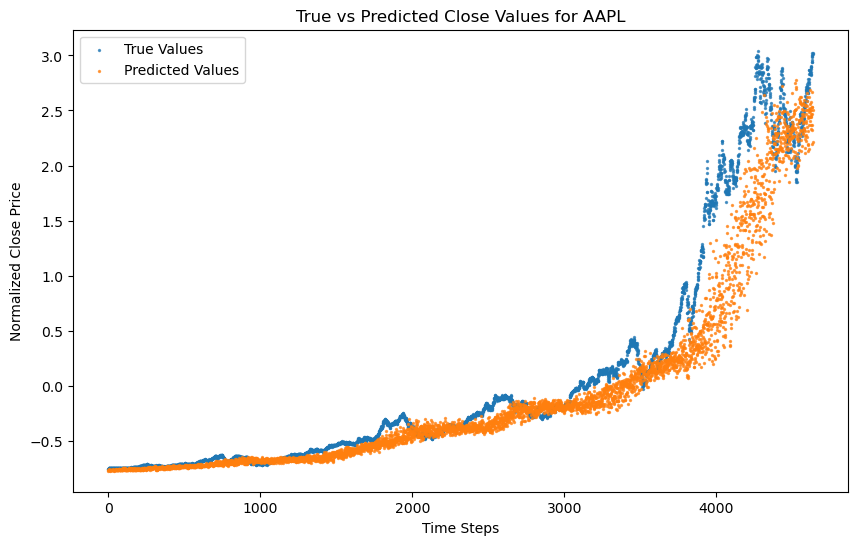

In [76]:
# Directory containing financial data
DATA_DIR = 'Financial Data'
scaler = StandardScaler()

# Load and preprocess cryptocurrency data
crypto = {}
for fn in os.listdir(os.path.join(DATA_DIR, 'cryptocurrencies')):
    crypto[fn] = pd.read_csv(os.path.join(DATA_DIR, 'cryptocurrencies', fn))
    crypto[fn]['Volume'] = crypto[fn]['Volume'].astype(float)
    crypto[fn].drop(columns=['Year'], inplace=True)
    crypto[fn].iloc[:, 1:] = scaler.fit_transform(crypto[fn].iloc[:, 1:])

# Load and preprocess currency data
currency = {}
for fn in os.listdir(os.path.join(DATA_DIR, 'currencies')):
    currency[fn] = pd.read_csv(os.path.join(DATA_DIR, 'currencies', fn))
    currency[fn].drop(columns=['Year', 'Volume'], inplace=True)
    currency[fn].iloc[:, 1:] = scaler.fit_transform(currency[fn].iloc[:, 1:])

# Load and preprocess stock data
stocks = {}
for fn in os.listdir(os.path.join(DATA_DIR, 'stocks')):
    stocks[fn] = pd.read_csv(os.path.join(DATA_DIR, 'stocks', fn))
    stocks[fn]['Volume'] = stocks[fn]['Volume'].astype(float)
    stocks[fn].drop(columns=['Symbol', 'Date'], inplace=True)
    stocks[fn].iloc[:, 1:] = scaler.fit_transform(stocks[fn].iloc[:, 1:])

stock = stocks['AAPL.csv']

# Define features and target variable for a specific stock (e.g., AAPL)
X = stock.values[:-1]
y_close = stock['Close'].shift(-1).dropna().values

# Define the pipeline steps
SW = SlidingWindow(size=10, stride=5)  # Sliding window parameters
PD = PearsonDissimilarity()           # Pearson dissimilarity for distance metric
VR = VietorisRipsPersistence(metric="precomputed")  # Persistence with precomputed metric
A = Amplitude()                    # Amplitude as a feature transformation
PE = PersistenceEntropy()         # Persistence entropy as a feature transformation
RFR = RandomForestRegressor(random_state=42, n_estimators=100)  # Random forest regressor

training_window = 500
y_close_pred = []
y_close_test = []
pipe_close = make_pipeline(SW, PD, VR, FeatureUnion([('A', A), ('PE', PE)]), RFR)
for i in tqdm(range(0, X.shape[0] - training_window)):
    X_train = X[i:i + training_window]
    y_close_train = y_close[i:i + training_window]

    pipe_close.fit(X_train, y_close_train)
    future_data = X[i + training_window: i + training_window + SW.size]
    if len(future_data) < SW.size or i + training_window + SW.size >= len(y_close):
        continue
    y_close_pred.append(pipe_close.predict(X[i + training_window: i + training_window + SW.size]))
    y_close_test.append(y_close[i + training_window + SW.size])
summarize(y_close_test, y_close_pred)